# Images

```json
{
    "photo_id":"Un_Og6jfhazVn7CxszkKEw",
    "business_id":"R1sIqGfKpF5f3HV3vyNsbg",
    "caption":"Drinks! Front is beer obviously. The pink one is the blackberry lemonade and the yellow one is the spicy margarita they made",
    "label":"drink"
}
```


In [1]:
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from matplotlib.image import imread
from PIL import Image
from PIL import ImageFilter
import cv2
from sklearn.cluster import KMeans
from scipy.spatial import distance
from sklearn import cluster, metrics
from sklearn.metrics import silhouette_score
from sklearn import manifold, decomposition

In [2]:
datafile = '../data/photos.json'
img_dir = '../data/photos/'
img_clean_dir = '../data/clean_photos/'
outputfile = '../data/clean_photos.csv'
outputfile_raw = '../data/raw_photos.csv'
chunksize = 10000

# Chargement des données
Dans un premier temps on charge les données qui sont dans un fichier photos.json et l'on ne prend que l'indentifiant de l'image (photo_id) et le label de cette image (label). C'est données sont chargée dans un data frame.

In [3]:
keep_cols = ['photo_id','label']
header = True
i = 0
for chunk in pd.read_json(datafile, chunksize=chunksize, orient='records', lines=True):
        #print(f"Chunk {i}")
        chunk.to_json('chunks_images/chunk_' + str(i) + '.json')        
        chunk = chunk[keep_cols]
        rawcsv = chunk[keep_cols]
        if header:
            chunk.to_csv(outputfile, index=False)        
            rawcsv.to_csv(outputfile_raw, index=False)        
        else:
            chunk.to_csv(outputfile, mode='a', header=False, index=False)
            rawcsv.to_csv(outputfile_raw, mode='a', header=False, index=False)
        i += 1
        header = False    

In [4]:
data = pd.read_csv('../data/clean_photos.csv')
data.head()

,photo_id,label
0,Un_Og6jfhazVn7CxszkKEw,drink
1,BFE1AFOs27scnnfeBf99ZA,drink
2,7t-C0r1JRdoVD9FS7M-N7Q,drink
3,rLnw0d-YYZvT9kR4y7h7_Q,drink
4,Cv5M8MDw8a5NEWvw2AQ4nw,drink


# Exploration des données
Le jeu de données contient 200 000 images, une seule image est dupliquée. Il y a 5 catégories :
 - interior
 - food
 - outside
 - menu
 - drink

Les images sont équitablement réparties avec dans les catégories (40 000 de chaque)

In [5]:
print(f"{data['photo_id'].shape[0]} images")
print(f"{data.duplicated(subset=['photo_id']).sum()} images dupliquées")

print("")
print("Données manquantes")
print(f"{data.isna().sum()}")
print("")
print(f"{len(data['label'].unique())} labels")
print(data['label'].unique())

200000 images
1 images dupliquées

Données manquantes
photo_id    0
label       0
dtype: int64

5 labels
['drink' 'food' 'interior' 'outside' 'menu']


In [6]:
data['label'].value_counts()

drink       40000
food        40000
interior    40000
outside     40000
menu        40000
Name: label, dtype: int64

# Ajout d'une colonne pour les categories
Nous ajoutons une colonne label_num qui corespond aux labels sous forme numérique. Cette colonne servira lors de l'&valuation des prédictions

In [7]:
data['label_num'] = data['label'].map({
    'drink'   :0,
    'menu'    :1,
    'food'    :2,
    'outside' :3,
    'interior':4
})

## Extrait des données
Pour cette exploration nous utiliserons un jeu de donnés partiel de 200 images par categories, soit 10 000 images au total

In [8]:
# Extrait des données
n_sample = 500
df_drink = data[data['label'] == 'drink'].sample(n=n_sample)
df_menu = data[data['label'] == 'menu'].sample(n=n_sample)
df_interior = data[data['label'] == 'interior'].sample(n=n_sample)
df_outside = data[data['label'] == 'outside'].sample(n=n_sample)
df_food = data[data['label'] == 'food'].sample(n=n_sample)

data = pd.concat([df_drink, df_menu, df_interior,df_outside, df_food ], ignore_index=True)

## Exemples d'images de chaque catégories

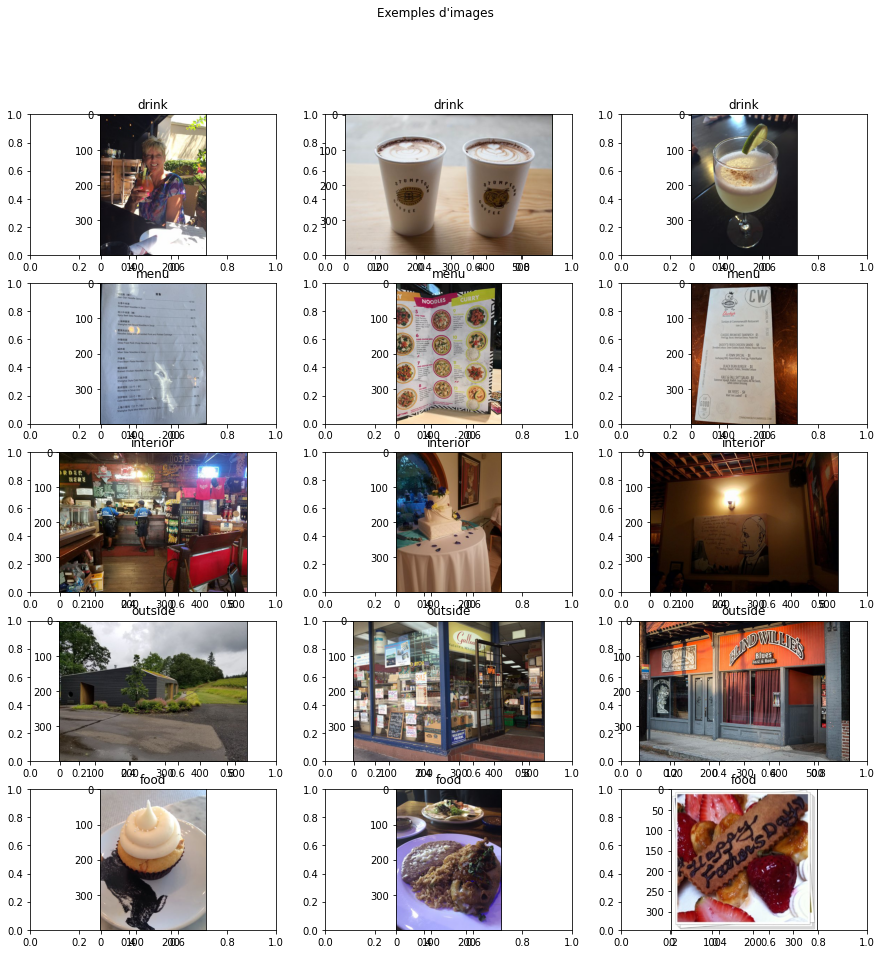

In [9]:
fig, ax = plt.subplots(5, 3, figsize=(15, 15))
fig.suptitle("Exemples d'images")


def display_images(sample, ax_idx):
    for index, row in sample.iterrows():    
        filename = img_dir + row['photo_id'] + '.jpg'    
        image = imread(filename)
        fig.add_subplot(5, 3, ax_idx)
    
        plt.imshow(image)
        plt.title(row['label'])
        ax_idx += 1
        
        


display_images(df_drink.sample(n=3, random_state=63),1)
display_images(df_menu.sample(n=3, random_state=63),4)
display_images(df_interior.sample(n=3, random_state=63),7)
display_images(df_outside.sample(n=3, random_state=63),10)
display_images(df_food.sample(n=3, random_state=63),13)

plt.show()


# Préparation des images
Les images vont subir 4 traitements :
 - Passage en nuances de gris
 - Mise à l'échelle en 224x224
 - Amélioration du constrate de l'image

In [10]:
def prepare_image(img):
    """
    Use filter on image
     - Gray scale
     - resize 224x224
     - Equilize histogramme
     - Contrast limited adaptive histogram equalization
     Then save the image in img_clean_dir
    """
    filename = img_dir + img + '.jpg' 
    
    # Read image and set as grey scale
    image = cv2.imread(filename,cv2.IMREAD_GRAYSCALE)
    
    # Resize image to 224x224 px
    image = cv2.resize(image, (224, 224))
    
    # Equilize histogramme
    image = cv2.equalizeHist(image)
    
    
    cv2.imwrite(img_clean_dir  + img +  '.jpg', image)    

## Exemple de traitement d'une image

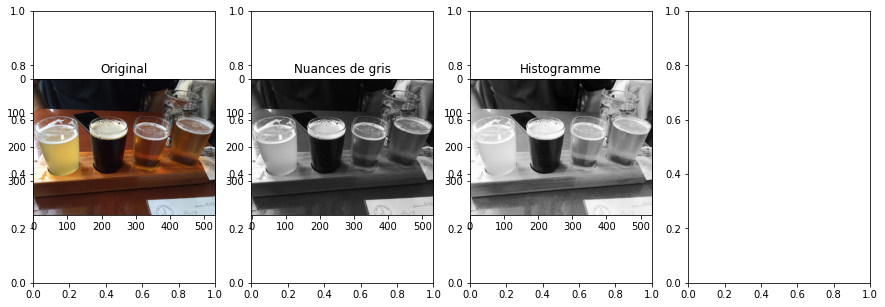

In [11]:
fig, ax = plt.subplots(1, 4, figsize=(15, 5))
filename = img_dir + data["photo_id"][11] + '.jpg' 

img = imread(filename)
fig.add_subplot(1, 4, 1)
plt.imshow(img)  
plt.title("Original")


# Gray
image = cv2.imread(filename)
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
cv2.imwrite('gray.jpg', image)  
gray = cv2.imread('gray.jpg')
fig.add_subplot(1, 4, 2)
plt.imshow(gray)  
plt.title("Nuances de gris")

# Equilize histogramme
image = cv2.equalizeHist(image)
cv2.imwrite('equalizeHist.jpg', image)  
image = cv2.imread('equalizeHist.jpg')
fig.add_subplot(1, 4, 3)
plt.imshow(image)  
plt.title("Histogramme")

plt.show()

## Application des filtres

In [12]:
none = data["photo_id"].apply(lambda x: prepare_image(x))

## Exemple d'image retraitées

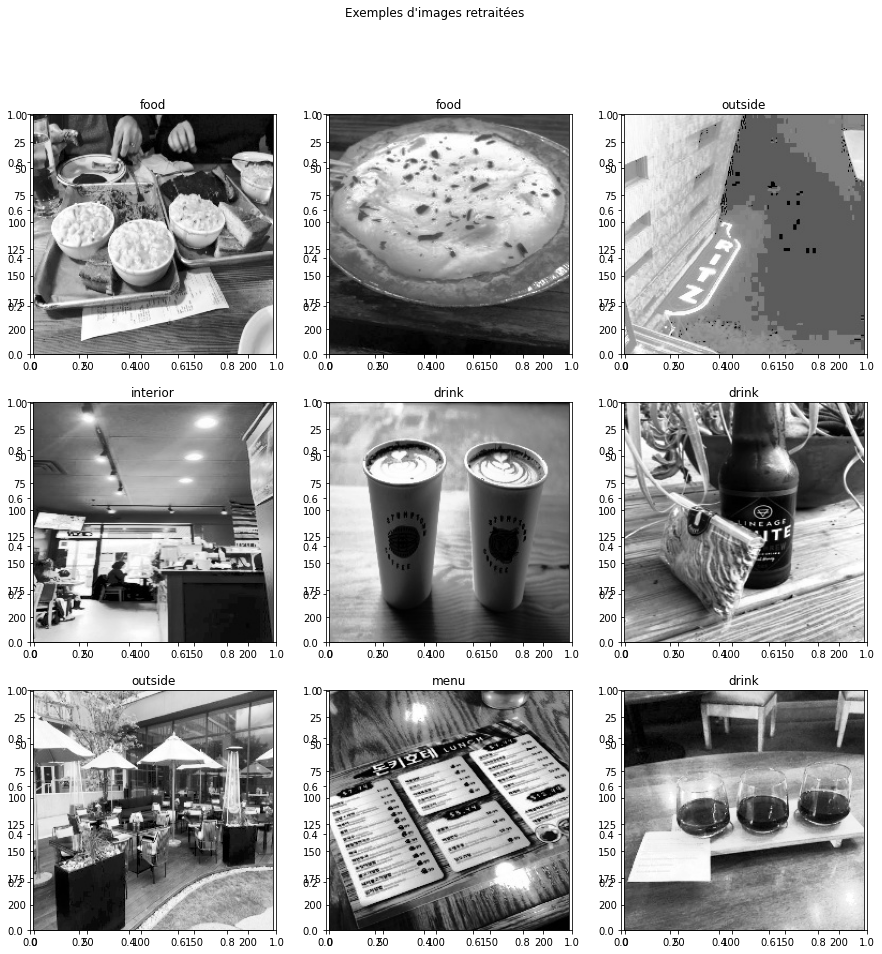

In [13]:
fig, ax = plt.subplots(3, 3, figsize=(15, 15))

fig.suptitle("Exemples d'images retraitées")
sample = data.sample(n=9, random_state=2611)
ax_idx = 1
for index, row in sample.iterrows():    
    filename = img_clean_dir + row['photo_id'] + '.jpg'    
    image = cv2.imread(filename)
    fig.add_subplot(3, 3, ax_idx)    
    plt.imshow(image)    
    plt.title(row['label'])
    ax_idx += 1
plt.show()

# SIFT et ORB
Utilisation des olgorithmes SIFT et de ORB pour détecter et identifier les éléments similaires entre les différentes images.
On constaera que SIFT trouve plus de pointde référence, lais ORB est plus rapide en traitement. Nous utiliserons pasr la suite l'algorithme ORB.

## Exemple de détection par SIFT et ORB

In [14]:
sample = data.sample(n=4, random_state=2611)

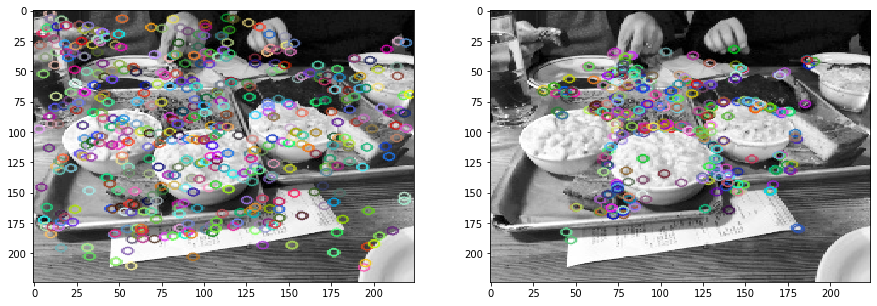

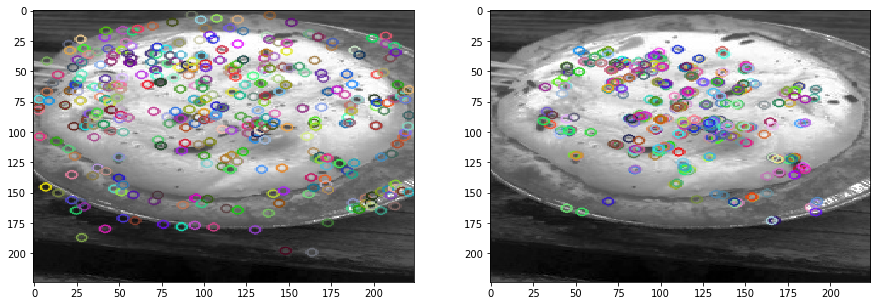

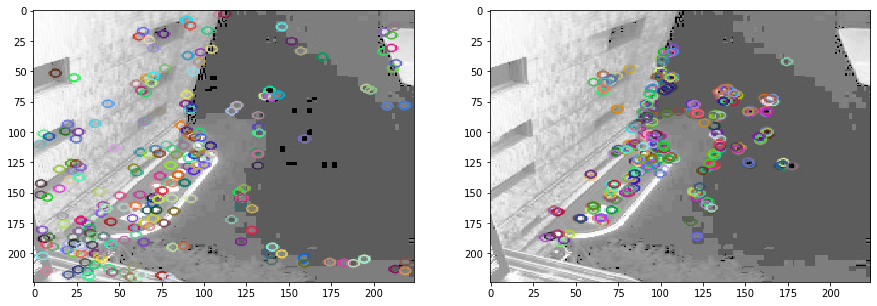

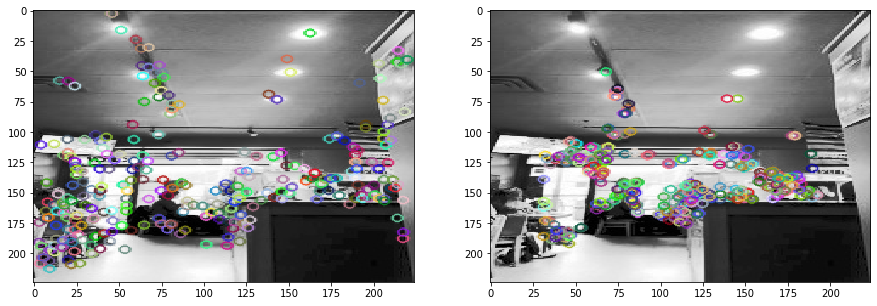

In [15]:
for index, row in sample.iterrows():
    
    filename = img_clean_dir + row['photo_id'] + '.jpg'  
    image = cv2.imread(filename)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
    
    # SIFT
    sift = cv2.SIFT_create()
    keypoints, descriptors = sift.detectAndCompute(image, None)
    image_sift = cv2.drawKeypoints(image, keypoints, None)
    ax1.imshow(image_sift, interpolation='nearest', aspect='auto')   
    
    # ORB
    orb = cv2.ORB_create()
    keypoints, descriptors = orb.detectAndCompute(image, None)
    image_orb = cv2.drawKeypoints(image, keypoints, None)
    ax2.imshow(image_orb, interpolation='nearest', aspect='auto')

    plt.show()

## Keypoints et descriptors de toutes les images
The ORB descriptors are vectors of 128 elements

In [16]:
def orb_keypoints_all(data):
    orb_keypoints = []
    orb = cv2.ORB_create()

    for index, row in data.iterrows(): 
        # Load cleaned image 
        filename = img_clean_dir + row['photo_id'] + '.jpg'
        image = cv2.imread(filename)

        # Get keypoints and descriptors
        keypoints, descriptors = orb.detectAndCompute(image, None)
        orb_keypoints.append(descriptors)    

    orb_keypoints_by_img = np.asarray(orb_keypoints, dtype=object)
    orb_keypoints_all    = np.concatenate(orb_keypoints_by_img, axis=0)

    print(f"{orb_keypoints_all.shape} descripteurs")
    
    return orb_keypoints_by_img, orb_keypoints_all

In [17]:
def sift_keypoints_all(data):
    sift_keypoints = []
    sift = cv2.SIFT_create()

    for index, row in data.iterrows(): 
        # Load cleaned image 
        filename = img_clean_dir + row['photo_id'] + '.jpg'
        image = cv2.imread(filename)

        # Get keypoints and descriptors
        keypoints, descriptors = sift.detectAndCompute(image, None)
        sift_keypoints.append(descriptors)    

    sift_keypoints_by_img = np.asarray(sift_keypoints, dtype=object)
    sift_keypoints_all    = np.concatenate(sift_keypoints_by_img, axis=0)

    print(f"{sift_keypoints_all.shape} descripteurs")
    
    return sift_keypoints_by_img, sift_keypoints_all

In [18]:
keypoints_by_img, keypoints_all = sift_keypoints_all(data)

(1164310, 128) descripteurs


# Clustering k-means
Pour déterminer le nombre de clusters optimal il existe 2 méthodes, la première qui consiste à prendre le nombre de clusters final et le multiplier par 100 ou la seconde qui prend l'entier de la racine carré de la longueur des descripteurs.

In [19]:
k_mult = 5 * 10  # Nb catégories * 10
kmeans_m = cluster.MiniBatchKMeans(n_clusters=k_mult, init_size=3*k_mult, random_state=63)
kmeans_m.fit(keypoints_all)
labels_m = kmeans_m.predict(keypoints_all)
print(f'Silhouette Score(n={k_mult}): {silhouette_score(keypoints_all, labels_m)}')

#k_square = int(round(np.sqrt(len(keypoints_all)),0))
#kmeans_s = cluster.MiniBatchKMeans(n_clusters=k_square, init_size=3*k_square, random_state=63)
#kmeans_s.fit(keypoints_all)
#labels_s = kmeans_s.predict(keypoints_all)
#print(f'Silhouette Score(n={k_square}): {silhouette_score(keypoints_all, labels_s)}')


Silhouette Score(n=50): 0.038276515901088715


## Histogramme pour chaque images
On créé un histogramme pour chaque image

In [20]:
def build_histogram(kmeans, des, image_num):
    res = kmeans.predict(des)
    hist = np.zeros(len(kmeans.cluster_centers_))
    nb_des=len(des)
    if nb_des==0 : print("problème histogramme image  : ", image_num)    
    for i in res:
        hist[i] += 1.0/nb_des
    return hist

# Création des matrices des histogrammes
hist_vectors=[]

for i, image_desc in enumerate(keypoints_by_img) :     
    hist = build_histogram(kmeans_m, image_desc, i) # Calcul des histogrammes
    hist_vectors.append(hist) 
im_features = np.asarray(hist_vectors)

# PCA

In [21]:
#from sklearn import manifold, decomposition

print("Dimensions dataset avant réduction PCA : ", im_features.shape)
pca = decomposition.PCA(n_components=0.99)
feat_pca= pca.fit_transform(im_features)
print("Dimensions dataset après réduction PCA : ", feat_pca.shape)

Dimensions dataset avant réduction PCA :  (2500, 50)
Dimensions dataset après réduction PCA :  (2500, 46)


# T-SNE
Nous utiliserons un algorthle T-SNE pour visualiser les données en 2 dimensions et ainsi visulaiser les catégories.

In [22]:
from sklearn import manifold, decomposition

tsne = manifold.TSNE(n_components=2, perplexity=30, 
                     n_iter=2000, init='random', random_state=63)
X_tsne = tsne.fit_transform(feat_pca)

df_tsne = pd.DataFrame(X_tsne[:,0:2], columns=['tsne1', 'tsne2'])
df_tsne["class"] = data["label_num"]
print(df_tsne.shape)

(2500, 3)


In [23]:
cls = cluster.KMeans(n_clusters=5, random_state=63)
cls.fit(X_tsne)
df_tsne["cluster"] = cls.labels_

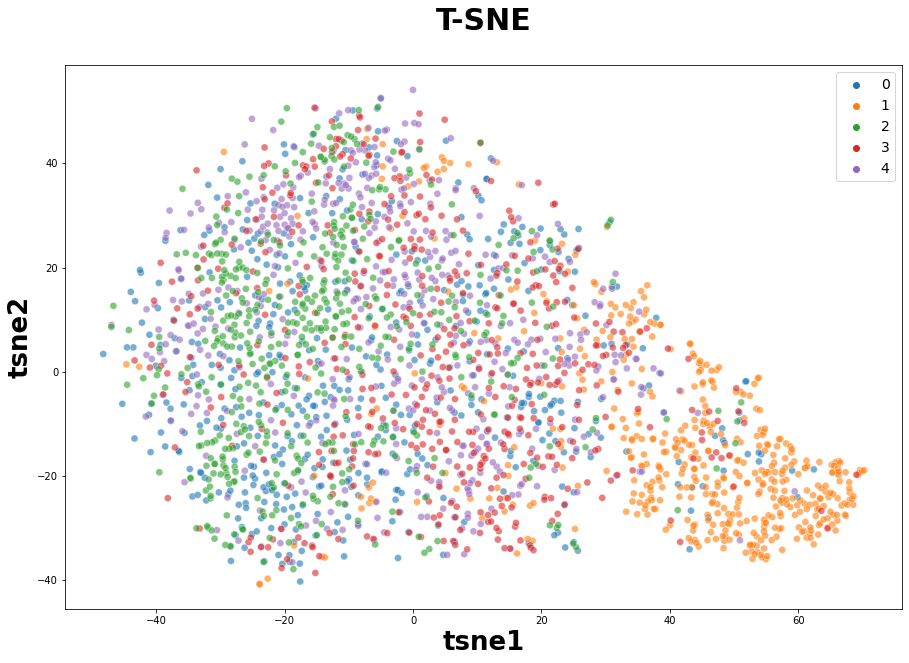

ARI :  0.1391038063639198


In [24]:
plt.figure(figsize=(15,10))
sns.scatterplot(
    x="tsne1", y="tsne2",
    hue="class",
    palette=sns.color_palette('tab10', n_colors=5), s=50, alpha=0.6,
    data=df_tsne,
    legend="brief")

plt.title('T-SNE', fontsize = 30, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
plt.legend(prop={'size': 14}) 

plt.show()

print("ARI : ", metrics.adjusted_rand_score(data['label_num'], cls.labels_))

# Matrice de confusion
Nous allons bâtir une matrice de confusion pour comparer les prediction des categories réelles.
Pour rappel des catégories sont les suivantes :

| Catégories | N°  |
| :--------- | --: |
| drink      | 0   |
|  menu      | 1   |
| food       | 2   |
| outside    | 3   |
| interior   | 4   |



In [25]:
conf_mat = metrics.confusion_matrix(data['label_num'], cls.labels_)
print(conf_mat)

[[117 148  35 131  69]
 [ 77  33 362   6  22]
 [ 71 111  12 197 109]
 [167 129  36  60 108]
 [131  89  13  86 181]]


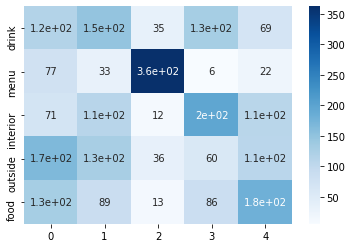

In [33]:
df_cm = pd.DataFrame(conf_mat, index = [label for label in data['label'].unique()],
                  columns = [i for i in "01234"])
plt.figure(figsize = (6,4))
sns.heatmap(df_cm, annot=True, cmap="Blues")

La représentation graphique des categories nous montre que l'algorithme n'arrive pas à bien dinstiguer les catégories, sauf pour la categorie "menu".

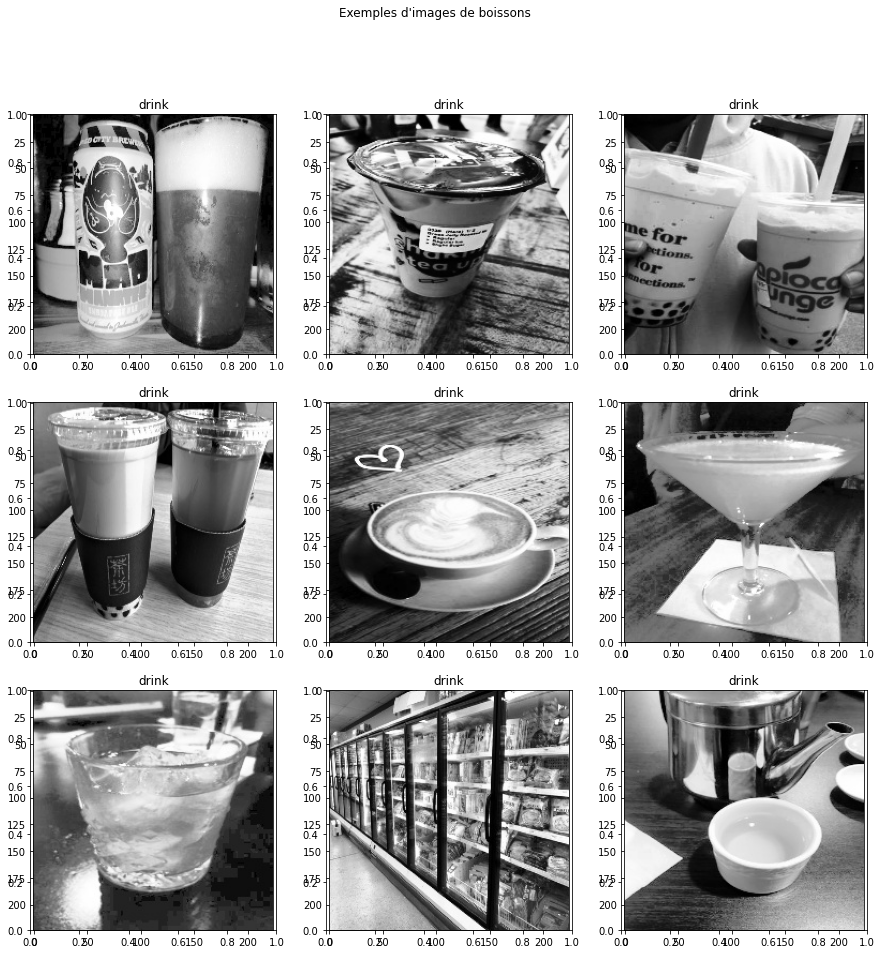

In [27]:
fig, ax = plt.subplots(3, 3, figsize=(15, 15))

fig.suptitle("Exemples d'images de boissons")
sample = df_drink.sample(n=9, random_state=2611)
ax_idx = 1
for index, row in sample.iterrows():    
    filename = img_clean_dir + row['photo_id'] + '.jpg'    
    image = cv2.imread(filename)
    fig.add_subplot(3, 3, ax_idx)    
    plt.imshow(image)    
    plt.title(row['label'])
    ax_idx += 1
plt.show()

Drink 51 %
Interior 50%
Food 60%

In [28]:
df_tsne.loc[0]

tsne1     -16.230360
tsne2      -4.589466
class       0.000000
cluster     3.000000
Name: 0, dtype: float64

In [29]:
data

,photo_id,label,label_num
0,rebwowR3Wcry44qmHRQjvA,drink,0
1,RJ1rrgVSBWntfVE4HOEurQ,drink,0
2,zxqBdo-Llwo71hQis7PqPA,drink,0
3,F3m0vFYyNe0zQoPzLZs8Sw,drink,0
4,WXoee98mfn2B4rARv2vp6Q,drink,0
...,...,...,...
2495,8-6lR4N5HdFN0Cw04jeufw,food,2
2496,fGaDqMFx9Xuj-oCubLR5pw,food,2
2497,6_rBl2-HaGVXtYs9oF_qmQ,food,2
2498,Md5hAyUyX2Hgf7IH-AXCxQ,food,2


In [30]:
data['label'].unique()

array(['drink', 'menu', 'interior', 'outside', 'food'], dtype=object)

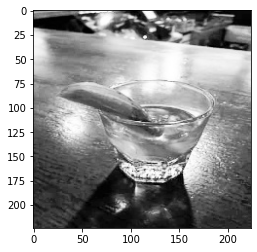

In [31]:
filename = img_clean_dir + data.loc[0]['photo_id'] + '.jpg'    
image = cv2.imread(filename)
plt.imshow(image)    